### Examine the Data

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

import pickle
import statsmodels.api as sm

In [2]:

# Read the dataset
df_raw = pd.read_csv('waterTank_Golden.csv', index_col=0, header=0, parse_dates=True)
df_raw.index.freq = 'ms'

df_raw.head()


,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


In [3]:
df_raw.isna().sum()

Tank1WaterLevel    0
Tank2WaterLevel    0
Tank1InFlow        0
Tank2OutFlow       0
wt3_valve          0
Tank3OutFlow       0
Tank2.level        0
dtype: int64

In [4]:
len(df_raw)

20001

### Plot the source data

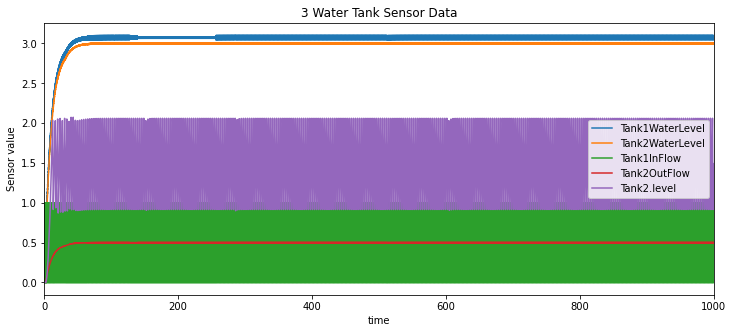

In [5]:
# ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
title = '3 Water Tank Sensor Data'
ylabel = 'Sensor value'
xlabel = ''
ax = df_raw['Tank1WaterLevel'].plot(legend=True, title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df_raw['Tank2WaterLevel'].plot(legend=True)
df_raw['Tank1InFlow'].plot(legend=True)
df_raw['Tank2OutFlow'].plot(legend=True)
# df_raw['wt3_valve'].plot(legend=True)
# df_raw['Tank3OutFlow'].plot(legend=True)
df_raw['Tank2.level'].plot(legend=True)
plt.show()

In [6]:
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    '''
    Hypothesis Test for Stationarity
    Pass in a time series and an optional title, return an ADF report
    '''
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

In [7]:
adf_test(df_raw['Tank1WaterLevel'])

Augmented Dickey-Fuller Test: 
ADF test statistics    -1.255233e+01
p-value                 2.192107e-23
#lags                   4.600000e+01
#observations           1.995400e+04
critical value (1%)    -3.430678e+00
critical value (5%)    -2.861685e+00
critical value (10%)   -2.566847e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Take the first order difference of the entire dataframe and re-run the dickey fuller test

In [8]:
# All the correlated features are stationary.
df_raw.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


### Normalisation of the dataset

In [9]:
def normalise_timeseries(data):
    # Calculate the mean and standard deviation for each feature
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    
    # Normalise each feature using standard deviation
    normalised_data = (data - means) / stds
#     return pd.DataFrame(normalised_data), means, stds
    return pd.DataFrame(normalised_data), means, stds


def denormalise_timeseries(data, means, stds):
    denormalised_data = (data * stds) + means
    return pd.DataFrame(denormalised_data)


normalised_data, means, stds = normalise_timeseries(df_raw)



In [10]:
# norm_vars = pd.concat([means, stds], axis=1)
# norm_vars

In [11]:
# norm_vars.to_csv(file_path)

### Save the mean and standard deviations globally or on disk

In [12]:
### METHOD ONE: USE %STORE MAGIC COMMAND
stored_norm_vars = pd.concat([means, stds], axis=1) # Stored Normalisation variables
%store stored_norm_vars

### METHOD TWO: SAVE AS A FILE
file_path = 'norm_var.csv'
norm_vars = pd.concat([means, stds], axis=1)
norm_vars.to_csv(file_path)

print(f'Normalisation variables saved successfully to {file_path}')

Stored 'stored_norm_vars' (DataFrame)
Normalisation variables saved successfully to norm_var.csv


In [13]:
df = normalised_data

In [14]:
df

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0.00,-13.751169,-13.647795,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
0.05,-13.751171,-13.647793,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
0.10,-13.736104,-13.647793,0.998751,-11.718138,-0.58372,-0.563189,-4.102034
0.15,-13.504895,-13.607095,0.998751,-11.718138,-0.58372,-0.563189,-4.102034
0.20,-13.402350,-13.512143,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
...,...,...,...,...,...,...,...
999.80,0.165423,0.123577,0.998751,0.126510,-0.58372,-0.563189,-0.162242
999.85,0.239056,0.140814,0.998751,0.133595,-0.58372,-0.563189,-0.105704
999.90,0.175745,0.174565,-1.001251,0.169767,-0.58372,-0.563189,-0.020868


In [15]:
# Train Test Split
nobs = 3000
# train = df[:-nobs]
train = df.iloc[:-nobs]
test = df.iloc[-nobs:]
len(train), len(test)

(17001, 3000)

### VAR Model Order Selection

In [33]:
# from statsmodels.tsa.vector_ar.var_model import VAROrderSelection
# Perform order selection using auto-arima
model_order = VAR(train)
# Select the best order based on a specific criterion (e.g. AIC, BIC)
selected_order = model_order.select_order()
# Get the selected order (lag length)
order = selected_order.selected_orders['aic']
min_aic_index = order
print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))

Order 43 has the least AIC value. Let us select p = 43 in the modelling


In [125]:
p = [1,2,3,4,5,6,7] # try with list of 7 p values
p = list(range(1,20))
aic, bic = [], []
for i in p:
    model = VAR(train)
    results = model.fit(i)
    aic.append(results.aic)
    bic.append(results.bic)
    print(f'VAR Order {i}')
    print('AIC: {}'.format(results.aic))
    print('BIC: {}'.format(results.bic))
    print()

min_aic = min(aic)
min_aic_index = aic.index(min_aic) + 1
min_bic = min(bic)
min_bic_index = bic.index(min_bic) + 1
print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))


VAR Order 1
AIC: -42.8843423266756
BIC: -42.85884266532912

VAR Order 2
AIC: -47.99214908265294
BIC: -47.94433476835406

VAR Order 3
AIC: -51.647839033641176
BIC: -51.57770778000928

VAR Order 4
AIC: -54.66835630285061
BIC: -54.57590582313148

VAR Order 5
AIC: -56.14652322978232
BIC: -56.03175123684803

VAR Order 6
AIC: -57.307421734247754
BIC: -57.17032594059661

VAR Order 7
AIC: -58.37300726398389
BIC: -58.213585381740316

VAR Order 8
AIC: -58.808255330898646
BIC: -58.626505071813135

VAR Order 9
AIC: -59.38141443112469
BIC: -59.17733350657368

VAR Order 10
AIC: -61.284744257857085
BIC: -61.05833037884292

VAR Order 11
AIC: -61.770844152374586
BIC: -61.5220950295254

VAR Order 12
AIC: -62.7165714450865
BIC: -62.44548478865615

VAR Order 13
AIC: -63.1810166902692
BIC: -62.887590210137176

VAR Order 14
AIC: -64.00347501493263
BIC: -63.68770642060396

VAR Order 15
AIC: -64.48857538996234
BIC: -64.15046239056753

VAR Order 16
AIC: -65.37002540710206
BIC: -65.009565711397

VAR Order 17
AI

In [126]:
# let's confirm that both the variables are included in the model
model.endog_names

['Tank1WaterLevel',
 'Tank2WaterLevel',
 'Tank1InFlow',
 'Tank2OutFlow',
 'wt3_valve',
 'Tank3OutFlow',
 'Tank2.level']

### Fit the VAR {{min_aic_index}}  model

In [127]:
min_aic_index

19

In [128]:
results = model.fit(min_aic_index)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 15, Jun, 2023
Time:                     13:22:50
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -67.3928
Nobs:                     16982.0    HQIC:                  -67.6793
Log likelihood:           408125.    FPE:                3.51567e-30
AIC:                     -67.8203    Det(Omega_mle):     3.32746e-30
--------------------------------------------------------------------
Results for equation Tank1WaterLevel
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.002970         0.000164          -18.091           0.000
L1.Tank1WaterLevel          0.330697         0.008725           37.903           0.000
L1.Tank2WaterLevel        

### Predict the next 20 values

In [129]:
# For predictions, VAR model uses .forecast() instead of predictions.
lag_order = results.k_ar
lag_order

19

In [130]:
df.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0.00,-13.751169,-13.647795,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
0.05,-13.751171,-13.647793,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
0.10,-13.736104,-13.647793,0.998751,-11.718138,-0.58372,-0.563189,-4.102034
0.15,-13.504895,-13.607095,0.998751,-11.718138,-0.58372,-0.563189,-4.102034
0.20,-13.402350,-13.512143,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034


In [131]:
steps = 20
# z = results.forecast(y=train.values[-lag_order:], steps = 20)
z = results.forecast(y=train.values, steps=steps)
z

array([[ 0.1655294 ,  0.12354131,  1.00005927,  0.1264925 , -0.5603872 ,
         0.95296732, -1.51126678],
       [ 0.27055356,  0.15466636,  0.99420227,  0.14422105, -0.57279468,
        -0.53273269, -1.44904419],
       [ 0.17570125,  0.17460906, -1.0086065 ,  0.16981796, -0.57249573,
        -0.54970639, -1.38765647],
       [ 0.05754884,  0.15644057, -0.99659496,  0.16823581, -0.59338145,
        -0.55007367, -1.30799793],
       [ 0.06888728,  0.12947985,  1.00315299,  0.14375485, -0.58337344,
        -0.57287482, -1.24840862],
       [ 0.20467238,  0.13016028,  0.9988082 ,  0.12737337, -0.59466642,
        -0.56104169, -1.16414575],
       [ 0.2704461 ,  0.15482264,  0.97588597,  0.14434728, -0.59050744,
        -0.57805835, -1.1066257 ],
       [ 0.13046073,  0.17359755, -1.00837434,  0.17531956, -0.60102323,
        -0.57199948, -1.0188361 ],
       [ 0.05703915,  0.1561709 , -0.98574207,  0.1680799 , -0.59712319,
        -0.58785588, -0.96144245],
       [ 0.12189686,  0.1227

In [132]:
len(z)

20

In [133]:
test

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
850.05,0.165423,0.123577,0.998751,0.126510,-0.58372,0.939866,-1.509549
850.10,0.270704,0.154650,0.998751,0.144185,-0.58372,-0.563189,-1.436865
850.15,0.175745,0.174565,-1.001251,0.169767,-0.58372,-0.563189,-1.380262
850.20,0.057638,0.156503,-1.001251,0.168293,-0.58372,-0.563189,-1.295175
850.25,0.068970,0.129598,0.998751,0.143823,-0.58372,-0.563189,-1.238449
...,...,...,...,...,...,...,...
999.80,0.165423,0.123577,0.998751,0.126510,-0.58372,-0.563189,-0.162242
999.85,0.239056,0.140814,0.998751,0.133595,-0.58372,-0.563189,-0.105704
999.90,0.175745,0.174565,-1.001251,0.169767,-0.58372,-0.563189,-0.020868


In [134]:
attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
df_forecast = pd.DataFrame(z, columns=attr)
df_forecast[:5]

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
0,0.165529,0.123541,1.000059,0.126492,-0.560387,0.952967,-1.511267
1,0.270554,0.154666,0.994202,0.144221,-0.572795,-0.532733,-1.449044
2,0.175701,0.174609,-1.008606,0.169818,-0.572496,-0.549706,-1.387656
3,0.057549,0.156441,-0.996595,0.168236,-0.593381,-0.550074,-1.307998
4,0.068887,0.129480,1.003153,0.143755,-0.583373,-0.572875,-1.248409


### Plot the results

In [135]:
len(train.iloc[-30:,:])

30

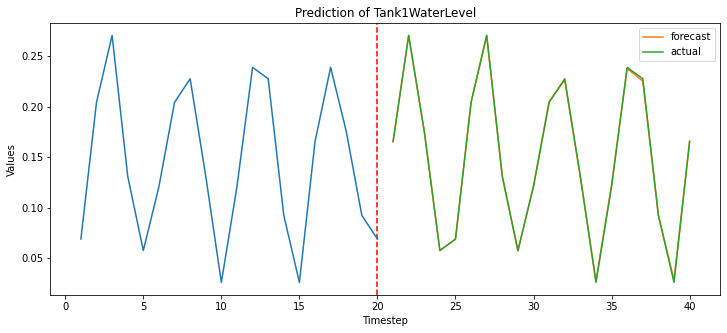

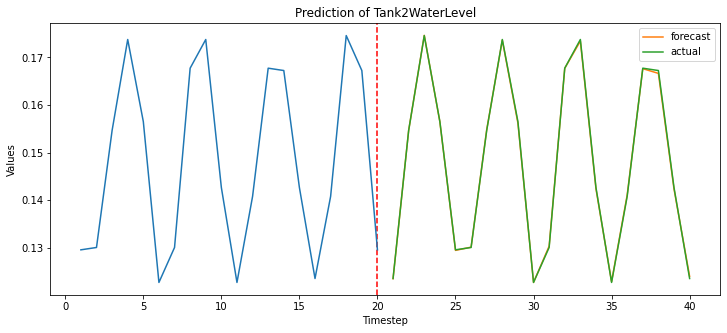

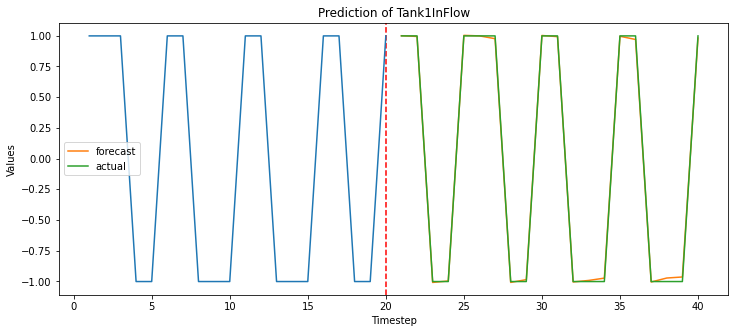

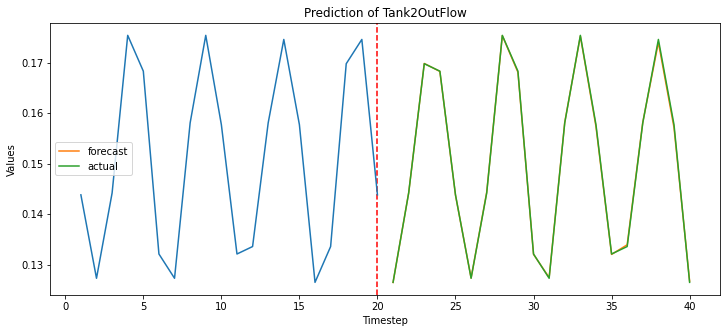

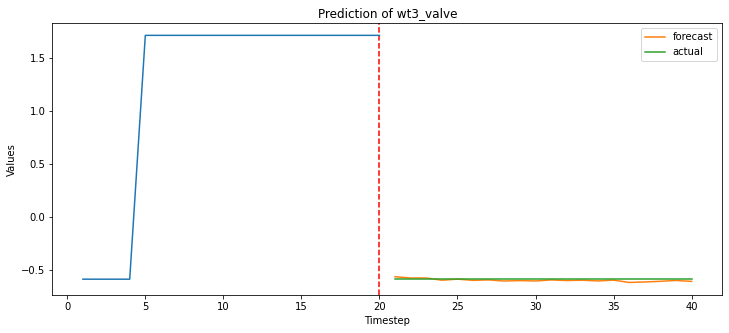

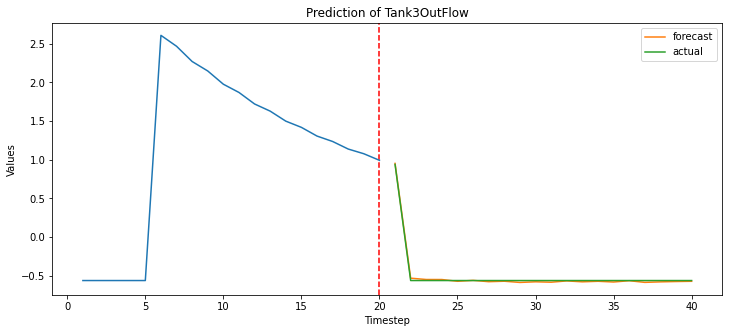

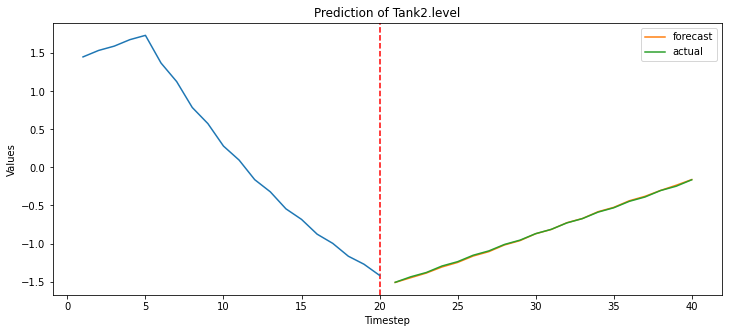

In [136]:
attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
input_length = 20
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index = pd.Index(list(range(1,input_length+1)))
#     actual = train.iloc[-lag_order:,:] # CORRECT BEFORE EDITING
    actual = train.iloc[-input_length:,:]
    
#     index = pd.Index(list(range(lag_order, lag_order + steps))) # CORRECT BEFORE EDITING
    index = pd.Index(list(range(input_length+1, input_length + steps +1)))
    actual = actual.set_index(actual_index)
    pred = df_forecast.set_index(index)
    actual_test = test.iloc[:input_length,:].set_index(index)
    # draw a vertical line at x=20
#     plt.axvline(x=lag_order, ls='--', color='red') # CORRECT BEFORE EDITING
    plt.axvline(x=input_length, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual.iloc[:,i])
    plt.plot(pred.iloc[:,i], label="forecast")
    plt.plot(actual_test.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

### Model Evaluation

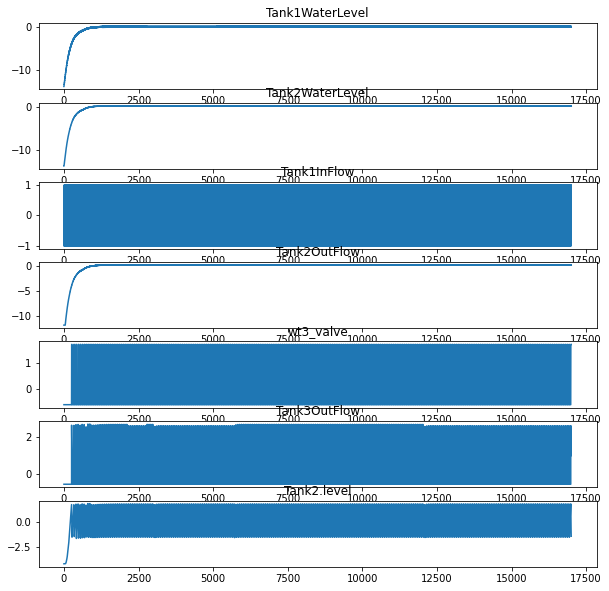

In [137]:
results.plot();

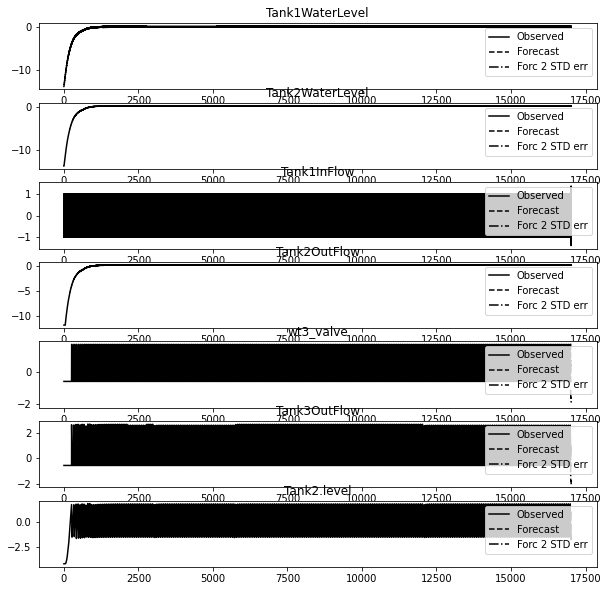

In [138]:
results.plot_forecast(20);

In [139]:
len(df_forecast)

20

### Model Evaluation (Quantitative)

In [140]:
# ### RUBBISH
# # attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
# RMSE = []
# for feat in attr:
#     RMSE.append(rmse(df[feat].iloc[:steps], df_forecast[feat]))

# print(RMSE)

In [141]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSE = []
for feat in attr:
    RMSE.append(rmse(pred[feat], actual_test[feat]))

print(RMSE)

[0.0011405367503115507, 0.00024872929641262567, 0.016180791449077102, 0.00024140936835143753, 0.015932234330922515, 0.015919132425305252, 0.007538254156699008]


In [142]:
def root_mse(x, y):
    if len(x) != len(y):
        return "Error: The two arguments must have the same length"
    mse = np.square(np.subtract(x, y)).mean()
    return np.sqrt(mse)

RMSEme = []
for feat in attr:
    RMSEme.append(root_mse(pred[feat], actual_test[feat]))

# tested = root_mse(df['Tank1WaterLevel'].iloc[:steps], df_forecast['Tank1WaterLevel'])
# tested
print(RMSEme)

[0.0011405367503115507, 0.00024872929641262567, 0.016180791449077102, 0.00024140936835143753, 0.015932234330922515, 0.015919132425305252, 0.007538254156699008]


### Save the model

In [143]:
# # Serialize andsave the model
# import pickle
# import statsmodels.api as sm
# with open('var_golden_model.pkl', 'wb') as f:
#     pickle.dump(results.params, f)
# print("Model saved!")

with open('var_golden_model.pkl', 'wb') as f:
    pickle.dump(results, f)
print("Model saved!")


Model saved!


### Define the faulty data
##### We need to define a different normalisation function that will use the previous values of means and stds.

In [144]:
# # Retrieve the saved and stored means and stds
# %store -r stored_norm_var
# old_means = stored_norm_var[0]
# old_stds = stored_norm_var[1]

def normalise_series(data, means, stds):
    normalised_data = (data - means) / stds
    return pd.DataFrame(normalised_data)



In [145]:
# old_means, old_stds

In [146]:
import pandas as pd
var_df = pd.read_csv("norm_var.csv", index_col=0)
var_df

,0,1
Tank1WaterLevel,3.042181,0.221231
Tank2WaterLevel,2.967675,0.217447
Tank1InFlow,0.500625,0.500000
Tank2OutFlow,0.493641,0.042126
wt3_valve,0.254137,0.435375
Tank3OutFlow,0.480682,0.853501
Tank2.level,1.448408,0.353095


In [147]:
old_means, old_stds = var_df["0"], var_df["1"]

In [148]:
# faulty_data = pd.read_csv('test_fault.csv', index_col=0, header=0, parse_dates=True)
faulty_df = pd.read_csv('test_extend.csv', index_col=0, header=0, parse_dates=True)
faulty_df.index.freq = 'MS'
num_obs = 3000

# normalised_data, means, stds = normalise_timeseries(faulty_data)
normalised_data = normalise_series(faulty_df, old_means, old_stds)
faulty_data = normalised_data

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty = faulty_data.iloc[:-num_obs]
test_faulty = faulty_data.iloc[-num_obs:]
len(train_faulty), len(test_faulty)

(12001, 3000)

In [149]:
faulty_data

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0.00,-13.751169,-13.647795,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
0.05,-13.751171,-13.647793,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
0.10,-13.736104,-13.647793,0.998751,-11.718138,-0.58372,-0.563189,-4.102034
0.15,-13.504895,-13.607095,0.998751,-11.718138,-0.58372,-0.563189,-4.102034
0.20,-13.402350,-13.512143,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
...,...,...,...,...,...,...,...
749.80,0.227724,0.167719,-1.001251,0.158064,-0.58372,-0.563189,-0.728886
749.85,0.131271,0.173739,-1.001251,0.175378,-0.58372,-0.563189,-0.672222
749.90,0.025990,0.142666,-1.001251,0.157702,-0.58372,-0.563189,-0.587091


### Load the model and reconstruct VAR

In [150]:
with open('var_golden_model.pkl', 'rb') as f:
    params = pickle.load(f)
    
golden_model = sm.tsa.VAR(train)
golden_model.params = params
golden_model_fit = golden_model.fit(min_aic_index)
# golden_model_fit = golden_model.fit()
golden_model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 15, Jun, 2023
Time:                     13:22:55
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -67.3928
Nobs:                     16982.0    HQIC:                  -67.6793
Log likelihood:           408125.    FPE:                3.51567e-30
AIC:                     -67.8203    Det(Omega_mle):     3.32746e-30
--------------------------------------------------------------------
Results for equation Tank1WaterLevel
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.002970         0.000164          -18.091           0.000
L1.Tank1WaterLevel          0.330697         0.008725           37.903           0.000
L1.Tank2WaterLevel        

### Forecast using faulty data

In [151]:
# Use the loaded model to make predictions or perform other analyses
forecast = golden_model_fit.forecast(y=train_faulty.values[-lag_order:], steps=20)
# forecast = golden_model_fit.forecast(params, start=len(train), end=len(train)+10)
forecast

array([[ 2.10956617e-01,  1.58887877e-01, -1.20534065e+00,
         1.50723495e-01,  4.89389743e+01,  3.05940049e+00,
         2.11018948e+02],
       [ 7.06760938e-02,  1.53817033e-01, -1.02825606e+00,
         1.62458876e-01,  8.97081758e+01,  6.84515574e+01,
         2.03087733e+02],
       [ 2.07570058e-02,  1.29753529e-01, -1.03813710e+00,
         1.42716204e-01,  1.24431084e+02,  1.21318131e+02,
         1.88470523e+02],
       [ 1.68015752e-01,  1.13873469e-01,  8.02410768e-01,
         1.12853883e-01,  1.53750326e+02,  1.63088790e+02,
         1.68619597e+02],
       [ 2.03269319e-01,  1.23663931e-01,  1.03844699e+00,
         1.16605478e-01,  1.78421580e+02,  1.95141661e+02,
         1.44691981e+02],
       [ 1.12821269e-01,  1.51559448e-01, -8.68192251e-01,
         1.49393990e-01,  1.98699934e+02,  2.19017382e+02,
         1.17769851e+02],
       [ 7.70285222e-02,  1.39644926e-01, -5.06201708e-01,
         1.44628525e-01,  2.15108881e+02,  2.35563189e+02,
         8.8727845

In [152]:
test_faulty

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
600.05,0.227723,0.167718,-1.001251,0.158063,1.713149,118.143843,200.645104
600.10,0.092377,0.167225,-1.001251,0.174568,1.713149,108.617680,184.214278
600.15,0.025989,0.142665,-1.001251,0.157701,1.713149,102.697693,174.003422
600.20,0.165422,0.123576,0.998751,0.126509,1.713149,94.417231,159.721195
600.25,0.239055,0.140813,0.998751,0.133594,1.713149,89.271261,150.845371
...,...,...,...,...,...,...,...
749.80,0.227724,0.167719,-1.001251,0.158064,-0.583720,-0.563189,-0.728886
749.85,0.131271,0.173739,-1.001251,0.175378,-0.583720,-0.563189,-0.672222
749.90,0.025990,0.142666,-1.001251,0.157702,-0.583720,-0.563189,-0.587091


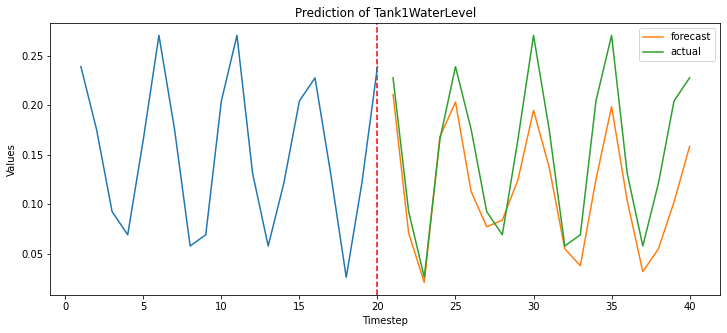

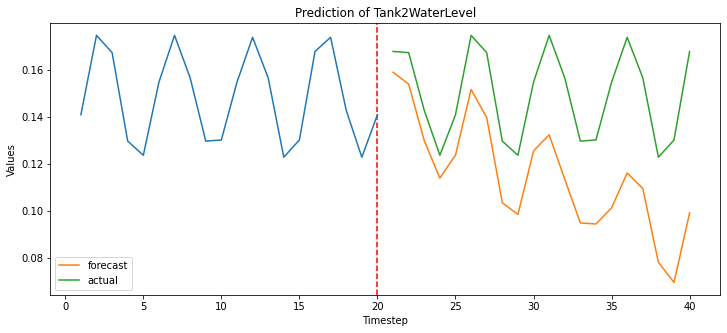

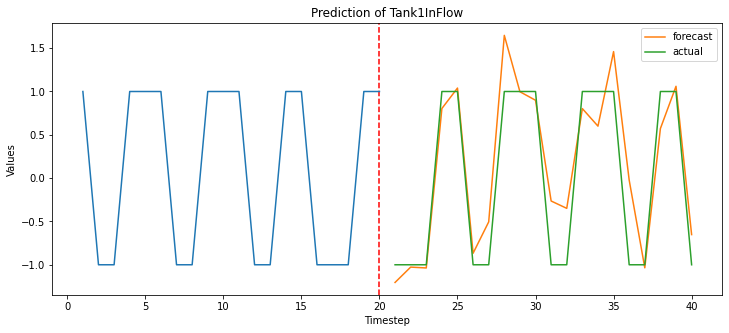

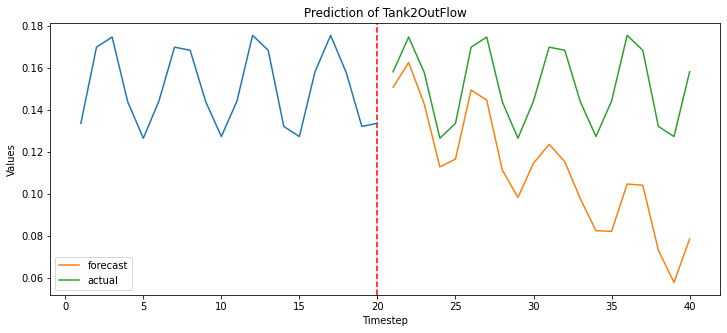

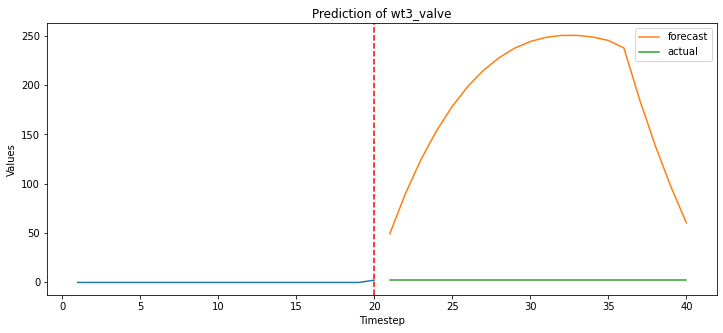

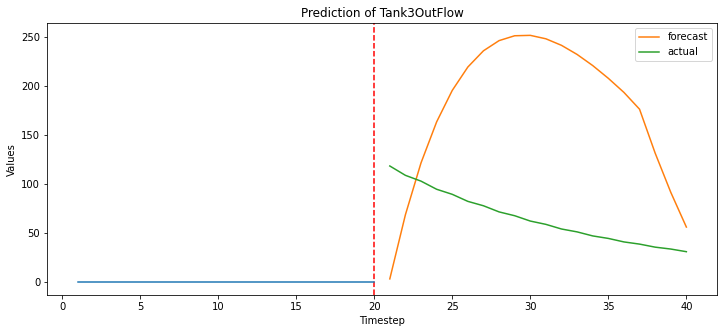

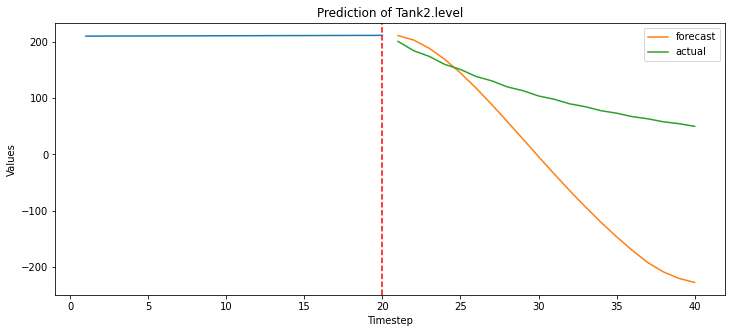

In [153]:
# attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
# # fault_forecast = pd.DataFrame(forecast, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
# fault_forecast = pd.DataFrame(forecast, columns=attr)
# input_length = 20
# # attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
# for i in range(len(attr)):
#     title = "Prediction of {}".format(attr[i])
#     actual_index_f = pd.Index(list(range(lag_order)))
#     actual_f = train_faulty.iloc[-lag_order:,:]
    
#     index_f = pd.Index(list(range(lag_order, lag_order + steps)))
#     actual_f = actual_f.set_index(actual_index_f)
#     pred_f = fault_forecast.set_index(index_f)
#     actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
#     # draw a vertical line at x=19
#     plt.axvline(x=lag_order, ls='--', color='red')
# #     pred = df_forecast
#     plt.title(title)
#     plt.xlabel("Timestep")
#     plt.ylabel("Values")
#     plt.plot(actual_f.iloc[:,i])
#     plt.plot(pred_f.iloc[:,i], label="forecast")
#     plt.plot(actual_test_f.iloc[:,i], label="actual")
#     plt.legend()
#     plt.show()


attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
# fault_forecast = pd.DataFrame(forecast, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
fault_forecast = pd.DataFrame(forecast, columns=attr)
input_length = 20
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(1,input_length+1)))
    actual_f = train_faulty.iloc[-input_length:,:]
    
    index_f = pd.Index(list(range(input_length+1, input_length + steps +1)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:input_length,:].set_index(index_f)
    # draw a vertical line at x=20
    plt.axvline(x=input_length, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [154]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(pred_f[feat], actual_test_f[feat]))

print(RMSEf)



[0.04947737899628814, 0.03819894427396719, 0.4134210904524917, 0.04554848890233299, 194.38297432997, 139.71886544650872, 162.83957024876503]


Evaluation of the model's performance can be done using the following:
- Accuracy
- Precision
- Recall
- F1 score

In [155]:
print("I want to stop the execution of the notebook here")
print(error)

I want to stop the execution of the notebook here


NameError: name 'error' is not defined

### Increasing the duration of faults

In [ ]:
df_test_extend = pd.read_csv('waterTank_Golden.csv', index_col=0, header=0, parse_dates=True)
df_test_extend.index.freq = 'MS'
faulty_data_extend = normalise_timeseries(df_test_extend)

# faulty_data_extend.index.freq = 'MS'
num_obs = 3000

# normalised_data_extend, means, stds = normalise_timeseries(faulty_data_extend)
# faulty_data_extend = normalised_data_extend
faulty_data_extend = df_test_extend

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty_extend = faulty_data_extend.iloc[:-num_obs]
test_faulty_extend = faulty_data_extend.iloc[-num_obs:]
len(train_faulty_extend), len(test_faulty_extend)

In [ ]:
# Use the loaded model to make predictions or perform other analyses
forecast_extend = golden_model_fit.forecast(y=train_faulty_extend.values[-lag_order:], steps=20)

In [ ]:
attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
# fault_forecast = pd.DataFrame(forecast_extend, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
fault_forecast = pd.DataFrame(forecast_extend, columns=attr)

# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [ ]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

### Fault Detection

In [ ]:
import scipy.stats as stats
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [ ]:
# ndf = pd.read_csv('waterTank_Golden.csv', index_col=0, header=0, parse_dates=True)
ndf = pd.read_csv('waterTank_ctrl_stuckAt0.csv', index_col=0)
ndf.plot(figsize=(16,6))

In [ ]:
# # Train best multivariate model
# var = VAR(fault_forecast)
# var_result = var.fit(min_aic_index)

# var_result.aic

In [ ]:
# Compute Train T2 metric (Hotelling's T-squared)
residuals_mean = results.resid.values.mean(axis=0)
residuals_std = results.resid.values.std(axis=0)

residuals = (results.resid.values - residuals_mean) / residuals_std
cov_residuals = np.linalg.inv(np.cov(residuals.T))

T = np.diag((residuals).dot(cov_residuals).dot(residuals.T))
T.shape

In [ ]:
# Compute UCL - Upper Control Limit

m = results.nobs
p = results.resid.shape[-1]
alpha = 0.01

# UCL = stats.f.ppf(1-alpha, dfn=p, dfd=m-p) * (p*(m+1)*(m-1)/(m*m-m*p))
UCL = stats.f.ppf(alpha, dfn=p, dfd=m-p) * (p*(m+1)*(m-1)/(m*m-m*p))
UCL

In [ ]:
# Set the UCL
UCL = 500

In [ ]:
# Plot Train T2 metric

plt.figure(figsize=(16,6))
# plt.plot(train.index[min_aic_index:], T)
plt.plot(train.index[min_aic_index:], T)
plt.ylabel('T-squared')
plt.axhline(UCL, c='red', linestyle='--')

In [2]:
"trick"

'trick'